# Influence

In [102]:
def grad(x,y,w,lam):
    ## gradient of logistic loss dl/dw
    # y is n*1
    # x is n*p data
    # w is p*1 column vector
    # g is n*p gradient matrix
    if len(y.shape)==1:
        y = np.reshape(y,(y.shape[0],1))
    if w.shape[0]==1:
        w = np.reshape(w, (w.shape[1],1))
    n = y.shape[0]
    a = np.multiply(y,x)
    b = (1+np.exp(np.multiply(y,np.dot(x,w))))
    c = lam*np.dot(x,w)
    g = -np.divide(a,b) + c
    
    return g

In [103]:
def hessian(x,y,w,lam):
    ## Hessian of logistic loss d^2l/dw^2
    # y is n*1
    # x is n*p data
    # w is p*1 column vector
    # h size p*p matrix
    if len(x.shape)==1:
        x = np.reshape(x,(1,x.shape[0]))
        y = np.array([y])
    
    if len(y.shape)==1:
        y = np.reshape(y,(y.shape[0],1))
    if w.shape[0]==1:
        w = np.reshape(w, (w.shape[1],1))
    D = np.zeros((x.shape[0],x.shape[0]))
    
    for i in range(x.shape[0]):
        sig = 1/(1+np.exp(-y[i]*np.dot(x[i],w)))
        D[i,i] = sig*(1-sig)
    
    h = (np.dot(np.dot(np.transpose(x), D), x)/y.shape[0]) + lam*x
    return h

In [104]:
def log_d(x,y,beta):
    # gradient of logistic loss dl/dbeta
    # y in n*1 response vector
    # x in n*p data matrix
    # beta in p*1 column vector
    # g in n*p gradient matrix
    if len(y.shape)==1:
        y = np.reshape(y,(y.shape[0],1))
    a = np.dot(x,beta)
    b = -np.transpose(np.multiply(np.transpose(y),np.transpose(x)))
#     print(x.shape,y.shape,beta.shape,a.shape,b.shape)
    g = np.divide(b,(1+np.exp(y*(a))))
    return g


In [105]:
def log_dd(x,y,beta):
    # Hessian of logistic loss d^2l/dbeta^2
    # y in R
    # x in R^p row vector
    # beta in R^p column vector
    # h size p*p matrix
#     print(x.shape,y.shape,beta.shape)
    if len(y.shape)==2:
        y = np.reshape(y,(y.shape[0],))
    if len(beta.shape)==2:
        beta = np.reshape(beta,(beta.shape[0],))
    h = np.divide(np.dot(np.transpose(x),x),(2+np.exp(-np.dot(beta,x))+np.exp(np.dot(beta,x))))
    return h

In [106]:
def inf_debug(X_train, y_train, X_trust, y_trust, gamma, lam):
    ## Influence function for binary classification

    n = y_train.shape[0]
    m = X_trust.shape[0]
    
    # prepare the RBF kernel matrix 
    K_train = rbf_kernel(X_train,X_train,gamma=gamma)
    K_trust = rbf_kernel(X_trust,X_train,gamma=gamma)
#     print(K_train.shape,y_train.shape)

    alpha = fit_model(K_train,y_train, lam)
    
    f1 = grad(K_trust,y_trust,alpha,lam)
    f2 = np.linalg.pinv(hessian(K_train,y_train,alpha,lam))
    f3 = grad(K_train,y_train,alpha,lam)
#     print(f1.shape, f2.shape, f3.shape,w.shape)
    
    inf = -np.dot(f1,np.dot(f2,np.transpose(f3)))
    
    # Xuezhou method
    
    # Compute (d alpha/d w)
#     print(K_train.shape, y_train.shape)
    dhdw = (1/n)*np.transpose(y_train)*np.transpose(K_train)
    dhdalpha = np.zeros((n,n))
    
    dhdalpha[:n,:n] = lam*K_train[:,:n]
    
    for i in range(n):
        dhdalpha = dhdalpha + (1/n)*log_dd(K_train[i,:],y_train[i],alpha);

    dalphadw = -np.dot(np.linalg.pinv(dhdalpha),dhdw)

    a = log_d(K_trust,y_trust,alpha)
#     print(a.shape)
    I_inf = np.dot(np.sum(a,0),dalphadw)
        
#     inf = [(i,inf[i]) for i in range(inf.shape[0])]
#     I_inf = [(i,I_inf[i]) for i in range(I_inf.shape[0])]
    
    return inf, I_inf


# experiments: influence

In [108]:
inf, I_inf = inf_debug(X_train, y_train, X_trust, y_trust, gamma, lam)
print(inf.shape,I_inf.shape)
I_inf = [(i,I_inf[i]) for i in range(I_inf.shape[0])]

(2, 100) (100,)


In [109]:
def get_relevant_influences(X_train, y_train, X_trust, y_trust, gamma, lam, inf):
    
    influences = [] 
    
    K = rbf_kernel(X_train, X_train, gamma=gamma)
    K_trust = rbf_kernel(X_trust, X_train, gamma=gamma)
    alpha = fit_model(K, y_train, lam)
    y_trust_pred,_ = predict(K_trust, alpha)
    
    l = []
    for i in range(len(y_trust)):
        if y_trust_pred[i] != y_trust[i]:
            pass
        l.append(i)
        
    for i in range(X_train.shape[0]):
        influences.append((i, np.sum(inf[l,i])))
                
    return influences

In [110]:
influences_1 = get_relevant_influences(X_train, y_train, X_trust, y_trust, gamma, lam, inf)
influences_2 = I_inf[:]

In [114]:
influences_1.sort(key = lambda x: x[1])
influences_1[:10],influences_1[-10:]

([(53, -19.27821690063039),
  (63, -8.847984359746244),
  (72, -8.12506161340106),
  (54, -6.447797471662447),
  (73, -1.8704624332320101),
  (47, -1.8517613330789906),
  (64, -1.279874640805445),
  (55, -1.155470844247906),
  (46, -1.1494905769717023),
  (82, -0.9914746673484229)],
 [(50, 2.927194937286507),
  (51, 3.8599186868805218),
  (80, 3.9548270696577243),
  (60, 4.8355489814916846),
  (70, 5.418782661792848),
  (81, 7.398532347482223),
  (52, 7.493271481066935),
  (61, 8.25528066588316),
  (71, 11.409184534522552),
  (62, 15.598040715072804)])

In [115]:
influences_2.sort(key = lambda x: x[1])
influences_2[:10], influences_2[-10:]

([(51, -6.993209890939752),
  (61, -6.983930162487695),
  (52, -6.976334218675845),
  (62, -6.81052499074724),
  (60, -6.6822992087177795),
  (50, -6.640321706108921),
  (41, -6.557441833316261),
  (42, -6.508600288166008),
  (71, -6.448982875747561),
  (40, -6.191941476021725)],
 [(55, 4.241422890188517),
  (74, 4.788479853649619),
  (83, 4.848971606673047),
  (64, 5.256251221147693),
  (54, 5.257286930526448),
  (82, 5.313152900727232),
  (73, 5.8584562271005325),
  (53, 6.2779044770832115),
  (72, 6.3092938320049825),
  (63, 6.373789828837971)])

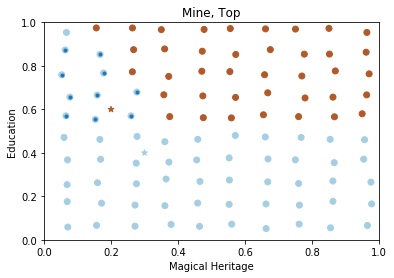

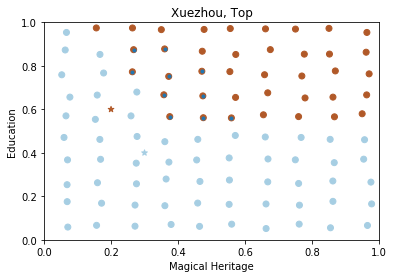

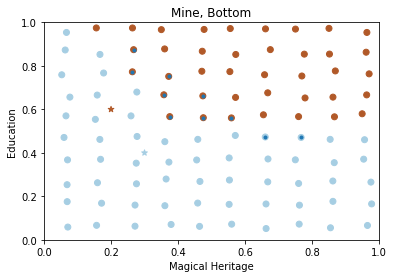

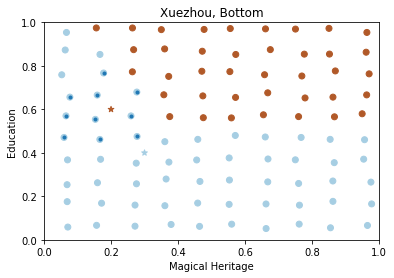

In [118]:
n = 10

top_n = True
visualize_top_influential_points(X_train, y_train, influences_1, n, top_n, X_trust, y_trust, title='Mine, Top')
visualize_top_influential_points(X_train, y_train, influences_2, n, top_n, X_trust, y_trust, title='Xuezhou, Top')

top_n = False
visualize_top_influential_points(X_train, y_train, influences_1, n, top_n, X_trust, y_trust, title='Mine, Bottom')
visualize_top_influential_points(X_train, y_train, influences_2, n, top_n, X_trust, y_trust, title='Xuezhou, Bottom')

# Kernel LR Model

In [12]:
import tensorflow as tf
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from tqdm import tqdm_notebook

In [136]:
def predict(K, alpha):
    pred = np.dot(K,alpha)
    pred_proba = 1/(1+np.exp(-pred))
    pred = np.sign(pred)
    return pred, pred_proba

In [137]:
g1 = tf.Graph()
with g1.as_default():
    lam_tf = tf.placeholder(tf.float32)
    K_tf = tf.placeholder(tf.float32, [100, 100])
    y_tf = tf.placeholder(tf.float32, [100,1])

    alpha_tf = tf.Variable(tf.zeros((100,1)))

    logistic_loss = tf.reduce_mean(-tf.log_sigmoid(y_tf*tf.matmul(K_tf, alpha_tf)))
    reg_loss = 0.5*lam_tf*tf.matmul(tf.matmul(alpha_tf, K_tf, transpose_a = True),alpha_tf)
    loss = logistic_loss + reg_loss
    opt = tf.train.AdamOptimizer().minimize(loss)
    init = tf.initializers.global_variables()

In [138]:
g2 = tf.Graph()
with g2.as_default():
    lam_tf2 = tf.placeholder(tf.float32)
    K_tf2 = tf.placeholder(tf.float32, [99, 99])
    y_tf2 = tf.placeholder(tf.float32, [99,1])

    alpha_tf2 = tf.Variable(tf.zeros((99,1)))

    logistic_loss2 = tf.reduce_mean(-tf.log_sigmoid(y_tf2*tf.matmul(K_tf2, alpha_tf2)))
    reg_loss2 = 0.5*lam_tf2*tf.matmul(tf.matmul(alpha_tf2, K_tf2, transpose_a = True),alpha_tf2)
    loss2 = logistic_loss2 + reg_loss2
    opt2 = tf.train.AdamOptimizer().minimize(loss2)
    init2 = tf.initializers.global_variables()

In [139]:
def fit_model(K_train,y_train,lam,verbose=False):
    n = K_train.shape[0]
    
    tf.reset_default_graph()
    
    if n==100:
#         print("Graph 1")
        with tf.Session(graph=g1) as sess:
            sess.run(init)

            prevloss = np.inf
            c = 0
            while True:
                _,al,ll,rl, l = sess.run([opt, alpha_tf, logistic_loss, reg_loss, loss], 
                            feed_dict={K_tf: K_train, y_tf:y_train, lam_tf: lam})
                c += 1
                if abs((prevloss - l)/l) < 1e-4:
                    if verbose:
                        print("Iterations for convergence:",c, "Loss: ", l)
                    break
    #             if c%1000==0:
    #                 print(c, ll, rl, l, prevloss)

                prevloss = l
        
    if n==99:
#         print("Graph 2")

        with tf.Session(graph=g2) as sess:
            sess.run(init2)

            prevloss = np.inf
            c = 0
            while True:
                _,al,ll,rl, l = sess.run([opt2, alpha_tf2, logistic_loss2, reg_loss2, loss2], 
                            feed_dict={K_tf2: K_train, y_tf2:y_train, lam_tf2: lam})
                c += 1
                if abs((prevloss - l)/l) < 1e-4:
                    if verbose:
                        print("Iterations for convergence:",c, "Loss: ", l)
                    break
    #             if c%1000==0:
    #                 print(c, ll, rl, l, prevloss)

                prevloss = l
    
    return al
        
        

In [140]:
al = fit_model(K_train, y_train, lam, verbose=True)

Iterations for convergence: 973 Loss:  [[0.1664869]]


In [141]:
print(al.shape)
a = [(i,al[i]) for i in range(len(al))]
a.sort(key = lambda x: x[1], reverse=True)

(100, 1)


In [142]:
a[:10]

[(63, array([0.4906308], dtype=float32)),
 (55, array([0.4900435], dtype=float32)),
 (64, array([0.48284203], dtype=float32)),
 (65, array([0.43849814], dtype=float32)),
 (56, array([0.42166564], dtype=float32)),
 (73, array([0.4060342], dtype=float32)),
 (74, array([0.3869649], dtype=float32)),
 (54, array([0.38337046], dtype=float32)),
 (75, array([0.37316024], dtype=float32)),
 (66, array([0.3702452], dtype=float32))]

In [143]:
pred, _ = predict(K_train, al)
np.sum(pred != y_train)

1

# experiments

In [144]:
from sklearn.metrics import log_loss

In [145]:
def custom_log_loss(y_true, y_proba):
    return -np.mean(np.multiply(y_true, np.log(y_proba))+np.multiply(1-y_true, np.log(1-y_proba)))

In [146]:
def calculate_influences_self(X_train, y_train, gamma, lam):
    influences = []
    K = rbf_kernel(X_train, X_train, gamma=gamma)
    
    alpha = fit_model(K,y_train,lam)
    
    pred, probas = predict(K, alpha)
    
    for i in tqdm_notebook(range(X_train.shape[0])):        
        K_point = K[i,:].reshape((1,X_train.shape[0]))
        
        orig_loss = custom_log_loss(y_train[i], probas[i])
        
        
        X_train_mod = np.delete(X_train, i, 0)
        y_train_mod = np.delete(y_train, i, 0)
        
        K_mod = rbf_kernel(X_train_mod, X_train_mod, gamma=gamma)
        
        alpha_ = fit_model(K_mod, y_train_mod, lam)
        
        K_mod_point = rbf_kernel(X_train[i].reshape((1,X_train.shape[1])),X_train_mod,gamma=gamma)
        
        point_pred, point_proba = predict(K_mod_point, alpha_)

        mod_loss = custom_log_loss(y_train[i], point_proba)
        
#         print(y_train[i],probas[i],orig_loss)
#         print(y_train[i],point_proba,mod_loss)

        influences.append((i, orig_loss - mod_loss))
        
    return influences

In [147]:
influences_self = calculate_influences_self(X_train, y_train, gamma, lam)

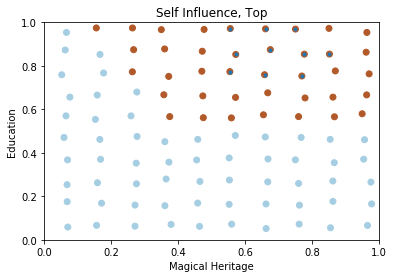

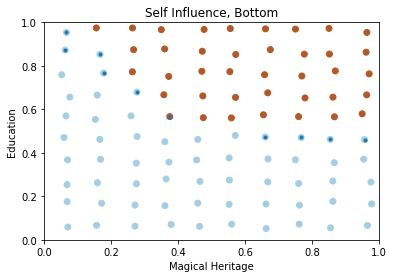

In [148]:
n = 10
top_n = True
visualize_top_influential_points(X_train, y_train, influences_self, n, top_n, title='Self Influence, Top')
top_n = False
visualize_top_influential_points(X_train, y_train, influences_self, n, top_n, title='Self Influence, Bottom')

Flip a single point, influence = change in training error

In [149]:
def calculate_influences_flip(X_train, y_train, gamma, lam):
    influences = []
    K = rbf_kernel(X_train, X_train, gamma=gamma)
    
    alpha = fit_model(K,y_train,lam)
    
    pred, probas = predict(K, alpha)
    
    orig_loss = custom_log_loss(y_train, probas)

    for i in tqdm_notebook(range(X_train.shape[0])):          
        
        y_train_mod = np.copy(y_train)
        y_train_mod[i] = 0 if (y_train_mod[i]==1) else 1 # flip single label
                
        alpha_ = fit_model(K, y_train_mod, lam)
        
        point_pred, point_proba = predict(K, alpha_)
        
        mod_loss = custom_log_loss(y_train, point_proba)
        
#         print(y_train[i],probas[i],orig_loss)
#         print(y_train[i],point_proba,mod_loss)

        influences.append((i, orig_loss - mod_loss))
        
    return influences

In [150]:
influences_flip = calculate_influences_flip(X_train, y_train, gamma, lam)

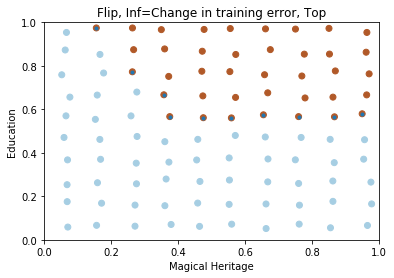

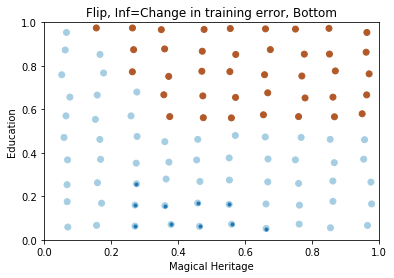

In [154]:
n = 10
top_n = True
visualize_top_influential_points(X_train, y_train, influences_flip, n, top_n, title='Flip, Inf=Change in training error, Top')
top_n = False
visualize_top_influential_points(X_train, y_train, influences_flip, n, top_n, title='Flip, Inf=Change in training error, Bottom')

Delete a single point, influence = change in training error

In [155]:
def calculate_influences_delete(X_train, y_train, gamma, lam):
    influences = []
    K = rbf_kernel(X_train, X_train, gamma=gamma)
    alpha = fit_model(K,y_train,lam)
    pred, probas = predict(K, alpha)
    orig_loss = log_loss(y_train, probas)
    
    for i in tqdm_notebook(range(X_train.shape[0])):
        X_train_mod = np.delete(X_train, i, 0)
        y_train_mod = np.delete(y_train, i, 0)
        
        K_mod = rbf_kernel(X_train_mod, X_train_mod, gamma=gamma)
        alpha_ = fit_model(K_mod,y_train_mod,lam)
        pred, probas = predict(K_mod, alpha_)
        mod_loss = log_loss(y_train_mod, probas)
        
        influences.append((i, mod_loss - orig_loss))
        
        
    return influences

In [156]:
influences_delete = calculate_influences_delete(X_train, y_train, gamma, lam)

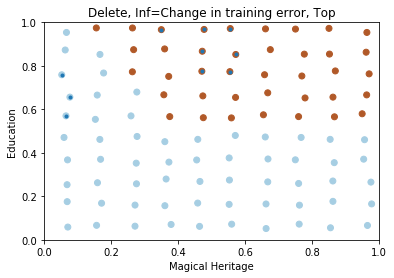

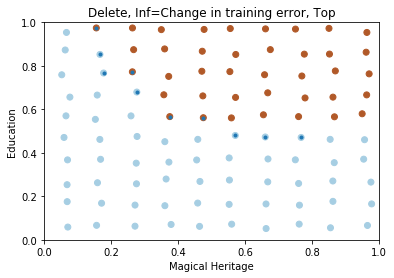

In [157]:
n = 10
top_n = True
visualize_top_influential_points(X_train, y_train, influences_delete, n, top_n, title='Delete, Inf=Change in training error, Top')
top_n = False
visualize_top_influential_points(X_train, y_train, influences_delete, n, top_n, title='Delete, Inf=Change in training error, Top')

Flip one label at a time, influence = change in loss of misclassified trusted items

In [158]:
def calculate_influences_on_trust_flip(X_train, y_train, X_trust, y_trust, gamma, lam):
    influences = []
    
    K = rbf_kernel(X_train, X_train, gamma=gamma)
    alpha = fit_model(K,y_train,lam)
    pred, probas = predict(K, alpha)
    
    K = rbf_kernel(X_train, X_train, gamma=gamma)
    K_trust = rbf_kernel(X_trust, X_train, gamma=gamma)
    alpha = fit_model(K, y_train, lam)
    y_trust_pred, _ = predict(K_trust, alpha)
    
    l = []
    for i in range(len(y_trust)):
        if y_trust_pred[i] != y_trust[i]:
            pass
            l.append(i)
    X_trust_misclassified = X_trust[l]
    y_trust_misclassified = y_trust[l]
    
    K_trust_misclassified = K_trust[l]
    _, trust_misclassified_proba = predict(K_trust_misclassified, alpha)
    orig_loss = custom_log_loss(y_trust[l], trust_misclassified_proba)
#     print(y_trust[l],trust_misclassified_proba,orig_loss)
    
    for i in tqdm_notebook(range(X_train.shape[0])):
        y_train_mod = np.copy(y_train)
        y_train_mod[i] = 0 if (y_train_mod[i]==1) else 1 # flip single label
        
        alpha_ = fit_model(K, y_train_mod, lam)
        
        y_trust_pred,_ = predict(K_trust, alpha_)
        l = []
        for j in range(len(y_trust)):
            if y_trust_pred[j] != y_trust[j]:
                pass
            l.append(j)

        X_trust_misclassified = X_trust[l]
        y_trust_misclassified = y_trust[l]

        K_trust_misclassified = rbf_kernel(X_trust_misclassified, X_train, gamma=gamma)
        
        _, trust_misclassified_proba = predict(K_trust_misclassified, alpha_)
        mod_loss = custom_log_loss(y_trust[l], trust_misclassified_proba)
        
#         print(y_trust[l],y_trust_misclassified,trust_misclassified_proba)
        
        influences.append((i, (mod_loss - orig_loss)))
                
    return influences

In [159]:
influences_flip_trust = calculate_influences_on_trust_flip(X_train, y_train, X_trust, y_trust, gamma, lam)

In [160]:
c = [(influences_flip_trust[i],X_train[i]) for i in range(len(influences_flip_trust))]
c.sort(key=lambda x:x[0][1], reverse=True)

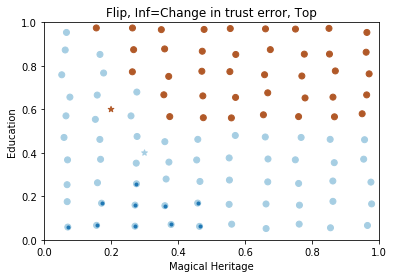

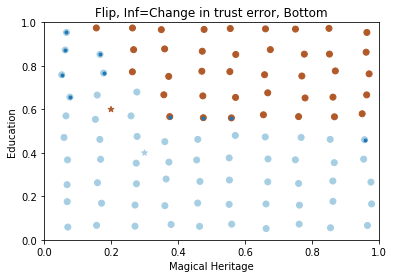

In [161]:
n = 10
top_n = True
visualize_top_influential_points(X_train, y_train, influences_flip_trust, n, top_n, X_trust, y_trust, title='Flip, Inf=Change in trust error, Top')
top_n = False
visualize_top_influential_points(X_train, y_train, influences_flip_trust, n, top_n, X_trust, y_trust, title='Flip, Inf=Change in trust error, Bottom')

In [162]:
def calculate_influences_on_trust_delete(X_train, y_train, X_trust, y_trust, clf, gamma):
    influences = []
    
    K = rbf_kernel(X_train, X_train, gamma=gamma)
    K_trust = rbf_kernel(X_trust, X_train, gamma=gamma)
    alpha = fit_model(K, y_train, lam)
    
    y_trust_pred,_ = predict(K_trust, alpha)
    l = []
    for i in range(len(y_trust)):
        if y_trust_pred[i] != y_trust[i]:
            l.append(i)
    X_trust_misclassified = X_trust[l]
    y_trust_misclassified = y_trust[l]
    
    K_trust_misclassified = rbf_kernel(X_trust_misclassified, X_train, gamma=gamma)
    orig_loss = -custom_log_loss(y_trust_pred[l], predict(K_trust_misclassified, alpha)[1])
    
    for i in tqdm_notebook(range(X_train.shape[0])):
        X_train_mod = np.delete(X_train, i, 0)
        y_train_mod = np.delete(y_train, i, 0)
        
        K_mod = rbf_kernel(X_train_mod, X_train_mod, gamma=gamma)
        K_trust = rbf_kernel(X_trust, X_train_mod, gamma=gamma)
        alpha_ = fit_model(K_mod, y_train_mod, lam)
        
        y_trust_pred,_ = predict(K_trust, alpha_)
        l = []
        for j in range(len(y_trust)):
            if y_trust_pred[j] != y_trust[j]:
                l.append(j)
        X_trust_misclassified = X_trust[l]
        y_trust_misclassified = y_trust[l]
        K_trust_misclassified = K_trust[l]
        
        mod_loss = -custom_log_loss(y_trust_pred[l], predict(K_trust_misclassified, alpha_)[1])
        
        influences.append((i, mod_loss - orig_loss))
                
    return influences

In [163]:
influences_delete_trust = calculate_influences_on_trust_delete(X_train, y_train, X_trust, y_trust, gamma, lam)

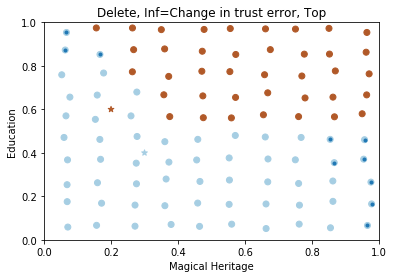

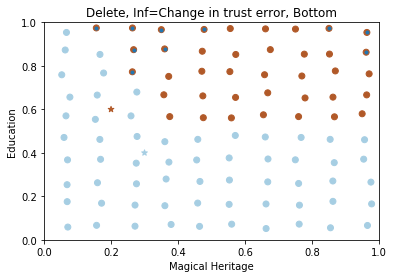

In [164]:
n = 10
top_n = True
visualize_top_influential_points(X_train, y_train, influences_delete_trust, n, top_n, X_trust, y_trust, title='Delete, Inf=Change in trust error, Top')
top_n = False
visualize_top_influential_points(X_train, y_train, influences_delete_trust, n, top_n, X_trust, y_trust, title='Delete, Inf=Change in trust error, Bottom')

# plotting

Plotting clusters...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import rbf_kernel

In [85]:
def visualize_top_influential_points(X_train, y_train, influences, n, top_n=True, X_trust=None, y_trust=None, title=None):
    if len(y_train.shape)==2:
        y_train = np.reshape(y_train,(y_train.shape[0],))
    
    
    influences.sort(key=lambda x:x[1], reverse=top_n)
    top_influence_indices = [i[0] for i in influences[:n]]
    
    top_influence_X = X_train[top_influence_indices,:]
    top_influence_y = y_train[top_influence_indices]
    
    plt.figure()
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, marker='o')
    
    plt.scatter(top_influence_X[:, 0], top_influence_X[:, 1], marker='.')
    
    if X_trust is not None:
        if len(y_trust.shape)==2:
            y_trust = np.reshape(y_trust,(y_trust.shape[0],))
        plt.scatter(X_trust[:, 0], X_trust[:, 1], c=y_trust, cmap=plt.cm.Paired, marker='*')
    
    if title:
        plt.title(title)
    plt.xlabel('Magical Heritage')
    plt.ylabel('Education')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.draw()
    plt.show()

In [3]:
# ----------------------------------------
# For plotting data and decision boundary
def plot_model(X_train, y_train, clf, sigma, X_trust=None, y_trust=None, title=None, 
													train_cluster_labels=None, trust_cluster_labels=None):

	X = np.zeros((10000,2))
	a = np.linspace(0,1,100)
	b = np.linspace(0,1,100)
	e, d = np.meshgrid(a, b)
	X[:,0] = np.reshape(e,(10000,))
	X[:,1] = np.reshape(d,(10000,))

	K = rbf_kernel(X, X_train, gamma=(-1/(2.0*sigma**2)))
	Z = clf.predict(K)
	probs = clf.predict_proba(K)[:, 1].reshape(e.shape)

	plt.figure()

	# Put the result into a color plot
	Z = Z.reshape(e.shape)
	plt.contour(e, d, probs, levels=[0.5])

	# Plot clusters
	if train_cluster_labels is not None:
		if trust_cluster_labels is not None:
			cluster_labels = np.concatenate([train_cluster_labels,trust_cluster_labels])
			X = np.vstack([X_train, X_trust])
			plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, marker='o', s=80)
		else:
			plt.scatter(X_train[:, 0], X_train[:, 1], c=train_cluster_labels, marker='o', s=80)

	# Plot the training points
	plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, marker='.')
	
	# Plot the trusted points
	if X_trust is not None:
		plt.scatter(X_trust[:, 0], X_trust[:, 1], c=y_trust, cmap=plt.cm.Paired, marker='X')

	if title is not None:
		plt.title(str(title))

	plt.xlabel('Magical Heritage')
	plt.ylabel('Education')
	plt.xlim(0, 1)
	plt.ylim(0, 1)
	plt.draw()

# HarryPotter

In [4]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

In [5]:
# for reproducibility, fix the random seed 
np.random.seed(123)

# the learner is hard coded to be kernel logistic regression.
# learner's parameters:
sigma = 0.4	# RBF kernel bandwidth
gamma = (1/(2.0*sigma**2))
lam = 1e-3

In [6]:
################### Harry Potter Toy Example ##################

# ----------------------------------------
# Generate "dirty" training data. 
# that is, we will plant some "historical bias" 
# in the form of labels: the Ministry of Magic refused to hire
# muggle-born graduates with high edcuation.

print("Creating training data...\n")

# Training Set size
n = 100 

# data points are on a uniform grid, then dithered with a Gaussian.
# x_1=magic heritage; x_2=education

X_train = np.zeros((n,2))
a = np.linspace(0.05, 0.95, num=int(np.sqrt(n)))
e, d = np.meshgrid(a, a)
X_train[:,0] = np.reshape(e,(n,))
X_train[:,1] = np.reshape(d,(n,))
X_train = X_train + 0.03*np.random.rand(n,2)

# the noiseless 'desired' label obeys y = sign(x_2 - 0.5)
y_clean = np.sign(X_train[:,1]-0.5)
y_clean = np.reshape(y_clean,(y_clean.shape[0],1))
# print(y_clean)

y_train = np.copy(y_clean)
y_train[(X_train[:,1]<(4*(X_train[:,0]-0.5)**2+0.5)) & (X_train[:,0]<0.5)] = -1
# print(y_train-y_clean)

Creating training data...



In [7]:
# --------------------------------------------------------------
# Generate trusted data
# we manually picked these two trusted items for pedagogical purpose
print("Creating trusted data...\n")

X_trust = np.array([[0.3, 0.4],[0.2, 0.6]])
y_trust = np.sign(X_trust[:,1]-0.5)
y_trust = np.reshape(y_trust,(y_trust.shape[0],1))
m = y_trust.shape[0]
c_value = 100  # Confidence parameters on trusted items are set to 100.
c = c_value*np.ones((m,1))

Creating trusted data...



In [8]:
# y[y==-1] = 0
# y_tilde[y_tilde==-1] = 0

In [9]:
print(X_train.shape, y_train.shape, X_trust.shape, y_trust.shape)

(100, 2) (100, 1) (2, 2) (2, 1)


In [10]:
K_train = rbf_kernel(X_train, X_train, gamma)
K_trust = rbf_kernel(X_trust, X_train, gamma)

In [11]:
print(K_train.shape,K_trust.shape)

(100, 100) (2, 100)
